## Advanced Lane Finding 

### The Project
---------
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

* Apply a distortion correction to raw images.

* Use color transforms, gradients, etc., to create a thresholded binary image.

* Apply a perspective transform to rectify binary image ("birds-eye view").

* Detect lane pixels and fit to find the lane boundary.

* Determine the curvature of the lane and vehicle position with respect to center.

* Warp the detected lane boundaries back onto the original image.

* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called `camera_cal`. The images in `test_images` are for testing your pipeline on single frames. If you want to extract more test images from the videos, you can simply use an image writing method like `cv2.imwrite()` i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `output_images` and include a description in your writeup for the project of what each image shows. The video called `project_video.mp4` is the video your pipeline should work well on.

The `challenge_video.mp4` video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions. The `harder_challenge.mp4` video is another optional challenge and is brutal!

If you're feeling ambitious (again, totally optional though), don't stop there! We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Polygon

In [2]:
# Display function to display two images side by side. 
def display_image_set(image1, title1, image2, title2, cmap = 'gray'):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (24,9))
    ax1.imshow(image1)
    ax1.set_title(title1, fontsize = 25)
    ax2.imshow(image2, cmap = 'gray')
    ax2.set_title(title2,  fontsize = 25)

### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [3]:
import glob
%matplotlib qt
%matplotlib inline

def calibrate_camera(images, nx=9, ny=6):
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    img = None
    for fname in images:    
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
   

    return ret, mtx, dist, rvecs, tvecs
        
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

ret, mtx, dist, rvecs, tvecs = calibrate_camera(images)

### 2. Apply distortion correction

#### 2a. Undistort a calibration image

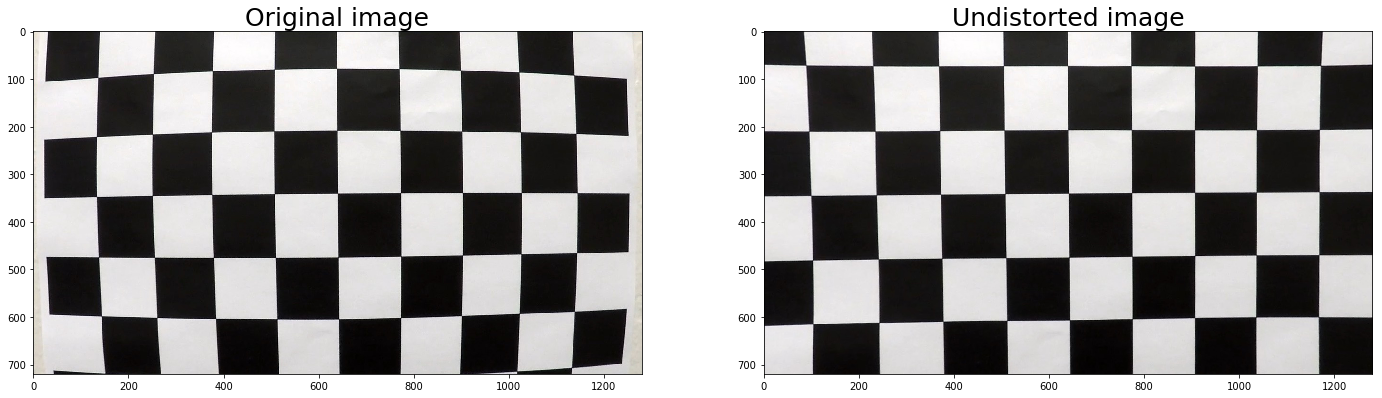

In [4]:
# Undistort a test image
img = mpimg.imread('./camera_cal/calibration1.jpg')
undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)    
display_image_set(img, 'Original image', undistorted_img, 'Undistorted image')

# Uncomment following lines to save image
#path = 'output_images/'
#cv2.imwrite(os.path.join(path , 'cal_1.jpg'), img)
#cv2.imwrite(os.path.join(path , 'undistorted_cal_1.jpg'), undistorted_img)        

#### 2b. Undistort test images

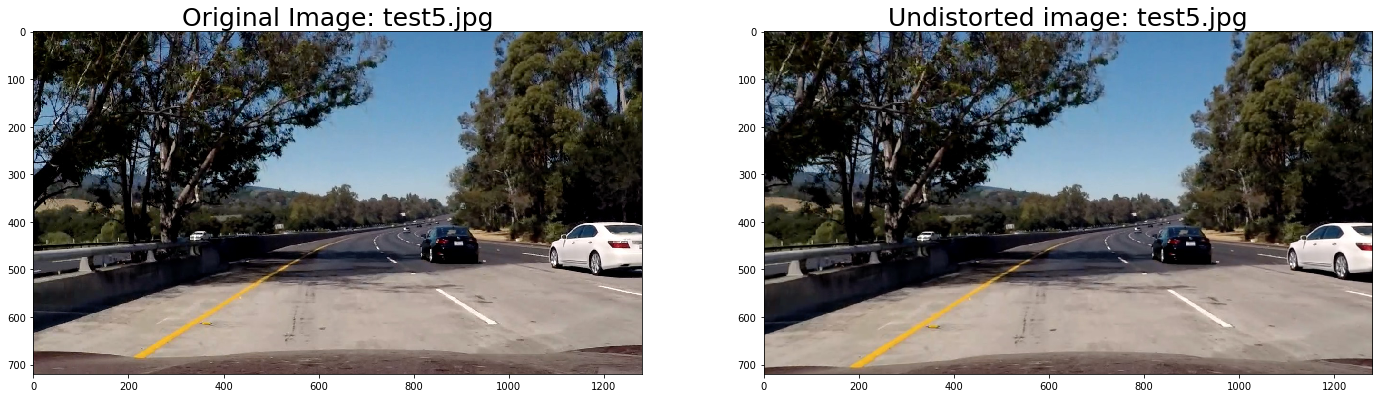

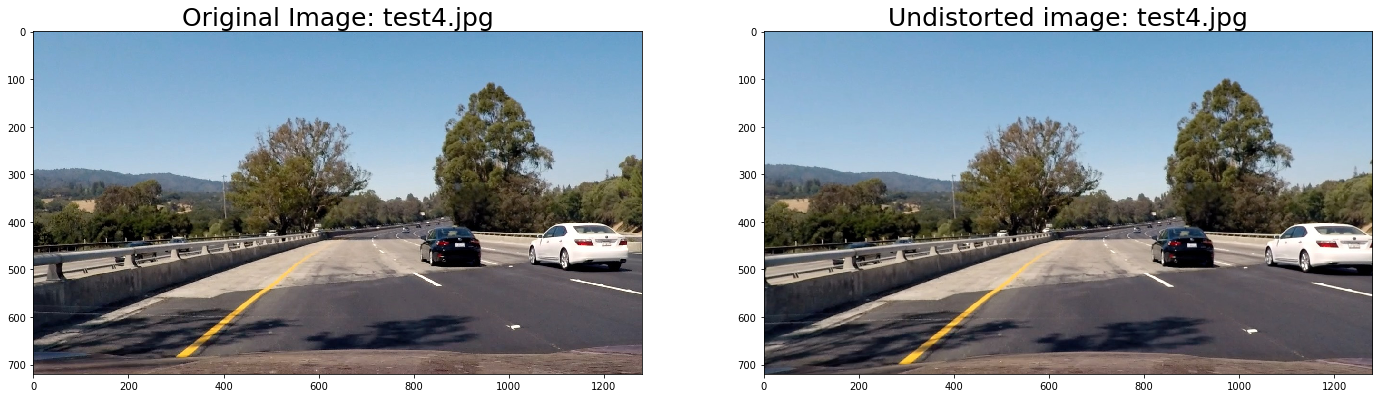

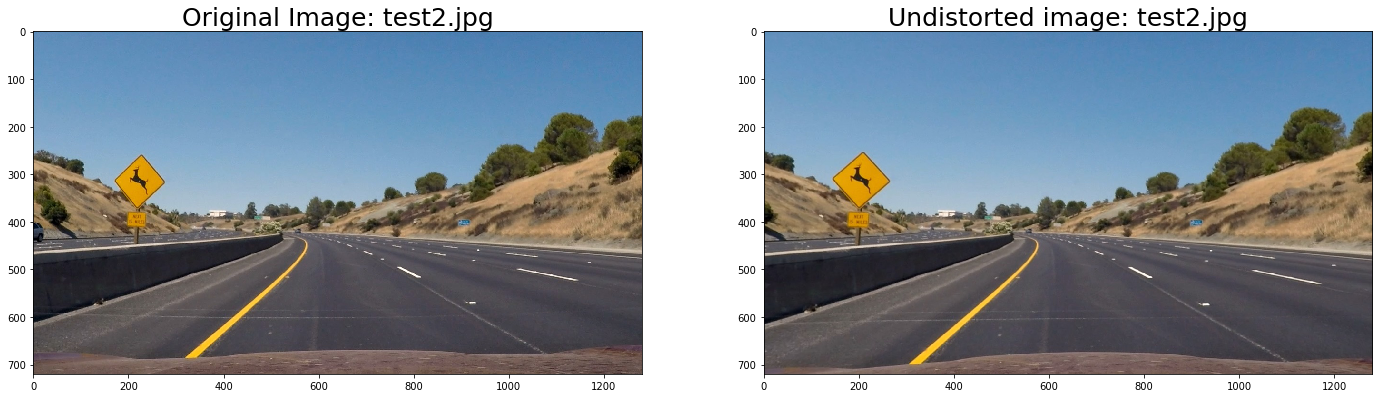

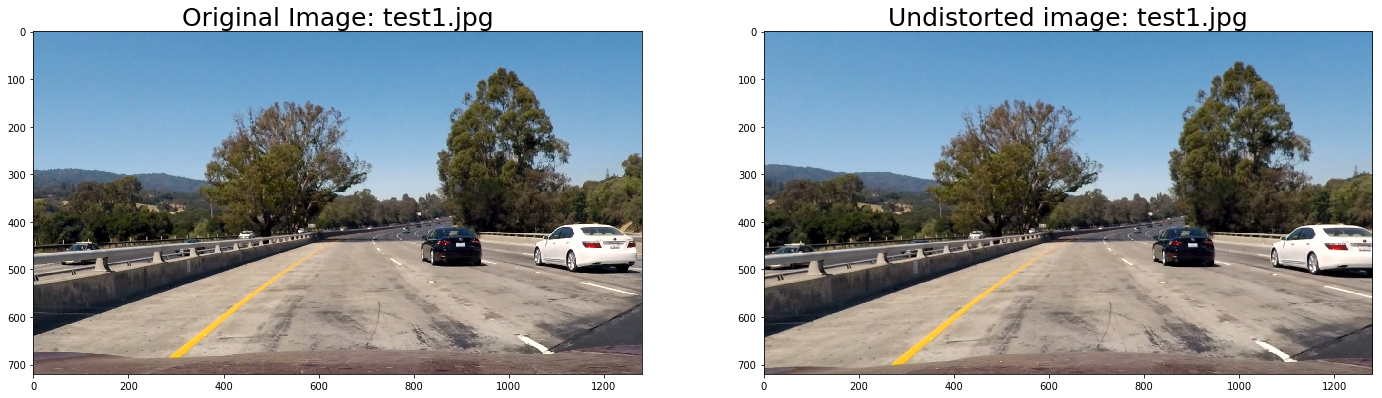

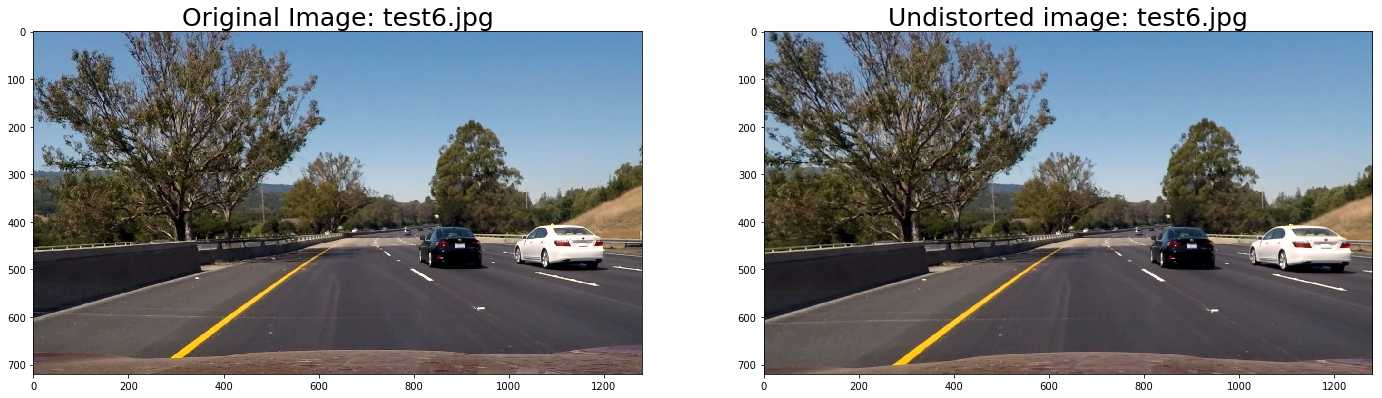

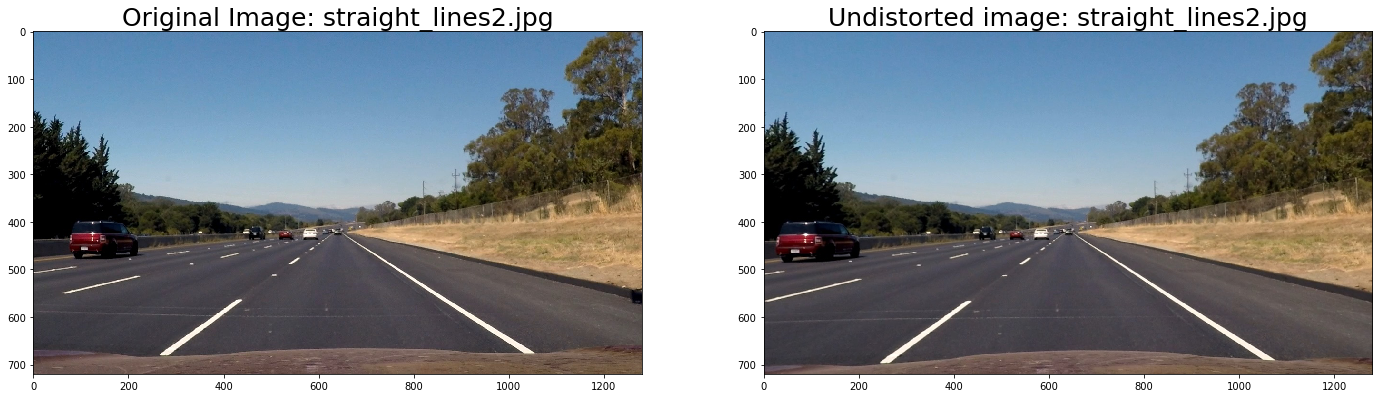

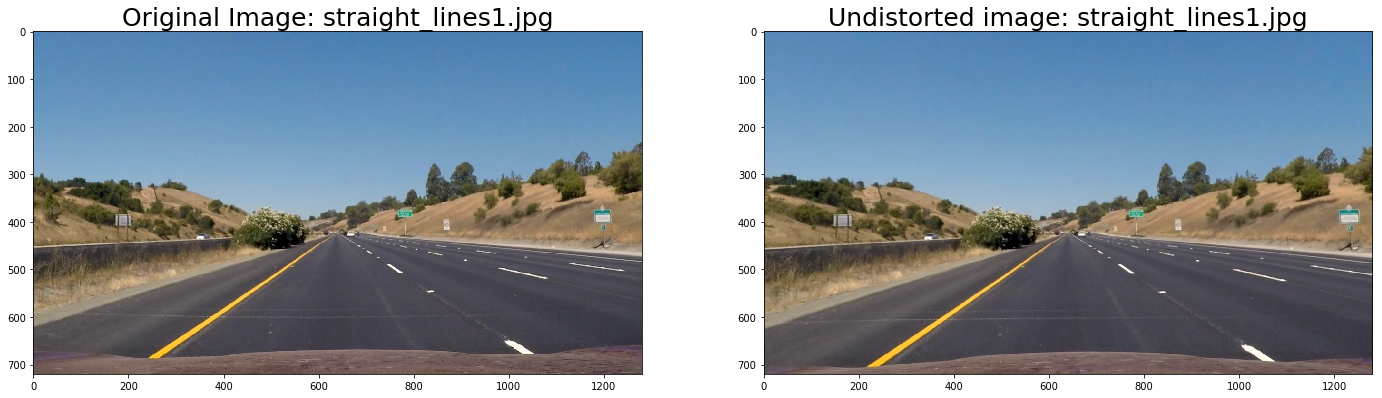

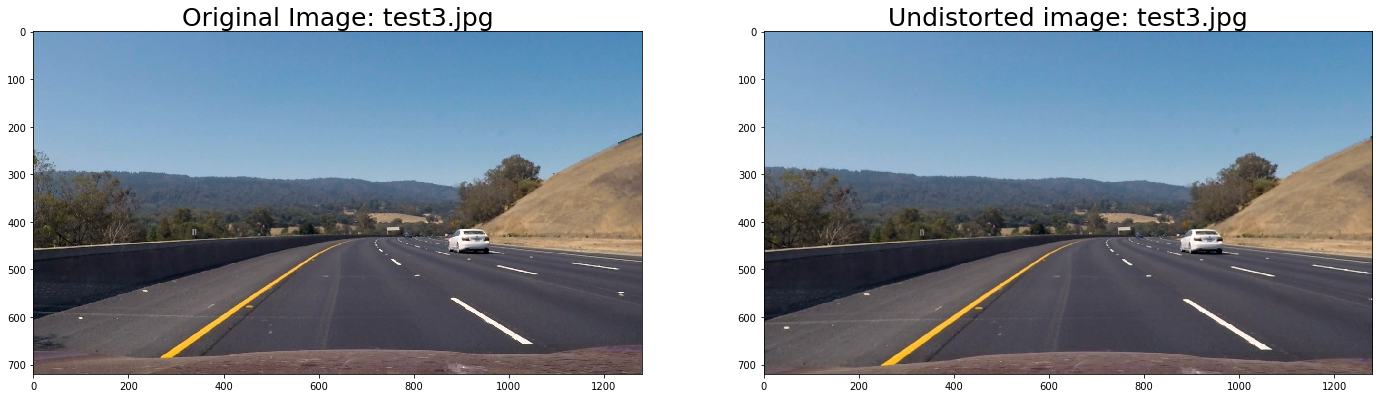

In [5]:
# Camera calibration on entire list of images in test_images folder. 
test_images = glob.glob('test_images/*.jpg')

for image in test_images:
    img = mpimg.imread(image)
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)    
    display_image_set(img, 'Original Image: ' + str(image).split('/')[1], undistorted_img, 'Undistorted image: ' + str(image).split('/')[1])
    
    # Uncomment following lines to save to output images folder
    path = 'output_images/'
    cv2.imwrite(os.path.join(path , 'orig_'+str(image).split('/')[1]), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    cv2.imwrite(os.path.join(path , 'undist_'+str(image).split('/')[1]), cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2BGR))      

### 3. Use color transforms, gradients, etc., to create a thresholded binary image

Steps:
1. **Sobel Operator:** We are specifying orientation as 'x' as taking the gradient in the x direction emphasizes edges closer to vertical.
2. **Direction of the Gradient** 
3. **Color Thresholds:** 
    * R & G Threshold 
    * L Channel Threshold 
    * S Channel Threshold 

In [6]:
def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
   
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary_output

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_output =  np.zeros_like(absgraddir)
    dir_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return dir_output

def get_thresholded_image(img):
    
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # apply gradient threshold on the horizontal gradient
    sx_binary = abs_sobel_thresh(img, 'x', 10, 200)
    
    # apply gradient direction threshold so that only edges closer to vertical are detected.
    dir_binary = dir_threshold(img, thresh=(np.pi/6, np.pi/2))
    
    # combine the gradient and direction thresholds.
    combined_condition = ((sx_binary == 1) & (dir_binary == 1))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    height, width = gray.shape
    
    # R & G thresholds.
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)    
    
    # color channel thresholds
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    # S channel 
    s_thresh = (100, 255)
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])
    
    # We put a threshold on the L channel to avoid pixels which have shadows and as a result darker.
    l_thresh = (120, 255)
    l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])

    # combine all the thresholds
    # A pixel should either be a yellowish or whiteish
    # And it should also have a gradient, as per our thresholds
    color_combined[(r_g_condition & l_condition) & (s_condition | combined_condition)] = 1
    
    
    return color_combined

### Example: Binary Thresholded Image

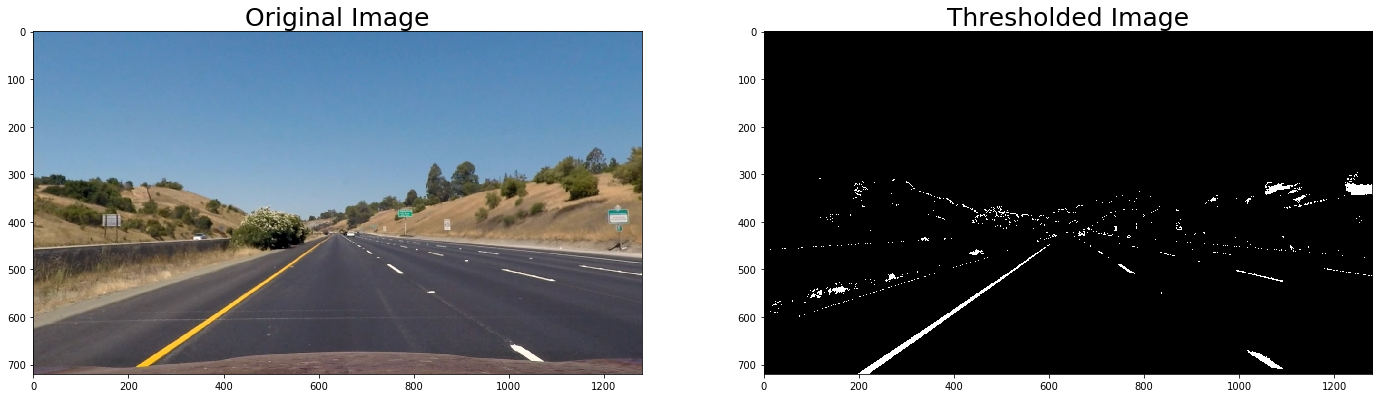

In [7]:
img = mpimg.imread('test_images/straight_lines1.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)
thresholded = get_thresholded_image(img)

# Plot the 2 images side by side
display_image_set(img, 'Original Image', thresholded, 'Thresholded Image')

# Uncomment following lines to save to output images folder
#path = 'output_images/'
#cv2.imwrite(os.path.join(path , 'before_thresh_'+str(image).split('/')[1]), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
#cv2.imwrite(os.path.join(path , 'after_thresh_'+str(image).split('/')[1]), thresholded)      

### 4. Apply a perspective transform to rectify binary image ("birds-eye view").

A perspective transform maps the points in a given image to different, desired, image points with a new perspective. Coordinates are manually chosen for source and destination by referring to a test image.

In [8]:
def warp(img):
    
    # Define calibration box in source (original) and destination (desired or warped) coordinates
    
    img_size = (img.shape[1], img.shape[0])
    
    # Four source coordinates
    # Vertices extracted manually for performing a perspective transform
    src = np.float32(
    [[220, 720], # bottom left
    [1110, 720], # bottom right
    [570, 470], # top left
    [722, 470]]) # top right

    # Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
    dst = np.float32(
    [[320, 720], # bottom left
    [920, 720], # bottom right
    [320, 1], # top left
    [920, 1]]) # top right
    
    # Compute the perspective transform, M (M is the perspective mapping - a matrix)
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Could compute the inverse also by swapping the input parameters to unwarp the image
    Minv = cv2.getPerspectiveTransform(dst,src)
    
    # To apply transform M to the original image to get the warped image. To do that I call the warpPerspective
    # function.
    
    # Create warped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)
    
    return warped, M, Minv



### Apply Perpective transform on binary thresholded image

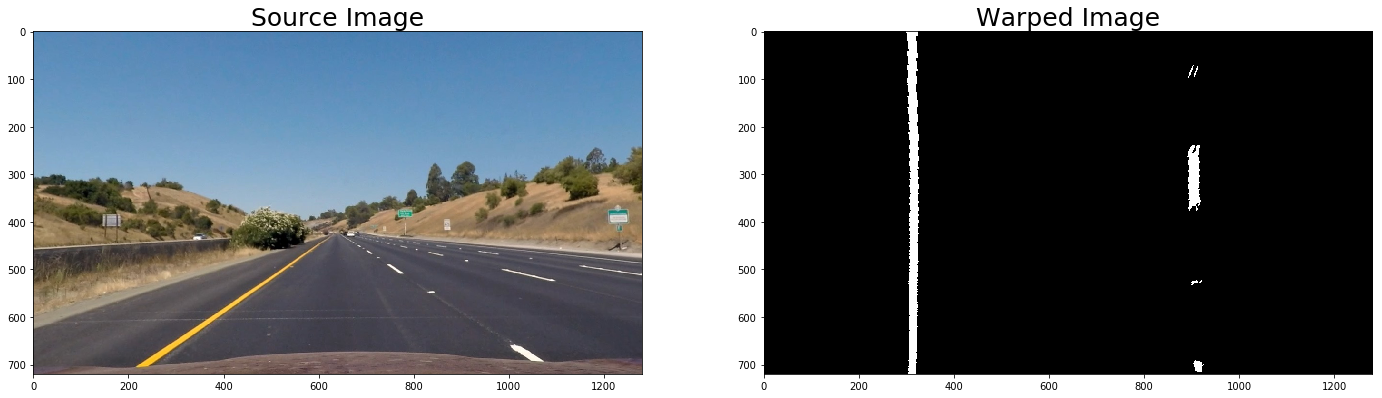

In [9]:
%matplotlib inline

# Get perspective transform
warped_im, M, Minv = warp(thresholded)

# Visualize undistortion
display_image_set(img, 'Source Image', warped_im, 'Warped Image')


### 5. Detect lane pixels and fit to find the lane boundary.
After applying calibration, thresholding, and a perspective transform to a road image, you should have a binary image where the lane lines stand out clearly. However, you still need to decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line.

### Histogram:
The peaks in a histogram will tell us the likely positions of lanes

In [10]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

### Create histogram of image binary activations

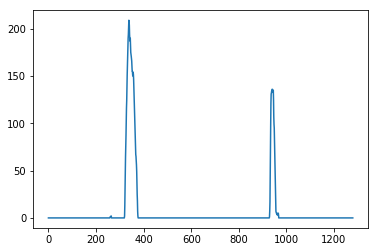

In [11]:
img = mpimg.imread('test_images/test3.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)
thresholded = get_thresholded_image(img)
warped_im, M, Minv = warp(thresholded)

# Create histogram of image binary activations
histogram = hist(warped_im)

# Visualize the resulting histogram
plt.plot(histogram)

### Sliding Window
With this histogram we are adding up the pixel values along each column in the image. In our thresholded binary image, pixels are either 0 or 1, so the two most prominent peaks in this histogram will be good indicators of the x-position of the base of the lane lines. We can use that as a starting point for where to search for the lines. From that point, we can use a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame.

In [12]:
def find_lane_pixels(binary_warped, return_img = False):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 100

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = nonzero[0]
    nonzerox = nonzero[1]
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)    

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    if(lefty.size == 0 or leftx.size == 0):
        return None, None
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    if(righty.size == 0 or rightx.size == 0):
        return None, None

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    # Generate x and y values for plotting
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
    if return_img is True:
        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        
        return out_img
        
    return left_fitx, right_fitx


### Identify lane line pixels in the rectified binary image

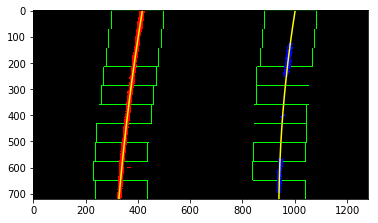

In [13]:
out_img = find_lane_pixels(warped_im, return_img=True)

plt.imshow(out_img)


### 6. Determine the curvature of the lane and vehicle position with respect to center.

Equation of radius of curvature that is used:
\begin{equation*}
\LARGE R_{curve} = \frac{(1 + (2Ay + B)^2)^{3/2}}{\left |2A \right |}
\end{equation*}

The mean of the lane pixels closest to the car gives us the center of the lane. The center of the image gives us the position of the car. The difference between the 2 is the offset from the center. Pixels are converted to meters.

In [14]:
def measure_radius_of_curvature(x_values):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

### Example computing the radius of curvature and center offset

In [15]:
left_fitx, right_fitx = find_lane_pixels(warped_im, return_img=False)

image_shape = img.shape
img_size = (image_shape[1], image_shape[0])
num_rows = warped_im.shape[0]
lane_center = (right_fitx[num_rows-1] + left_fitx[num_rows-1])/2

# compute the radius of curvature
left_curve_rad = measure_radius_of_curvature(left_fitx)
right_curve_rad = measure_radius_of_curvature(right_fitx)
average_curve_rad = (left_curve_rad + right_curve_rad)/2
curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
    
# compute the offset from the center
lane_center = (right_fitx[num_rows-1] + left_fitx[num_rows-1])/2
xm_per_pix = 3.7/700 # meters per pixel in x dimension
center_offset_pixels = abs(img_size[0]/2 - lane_center)
center_offset_mtrs = xm_per_pix*center_offset_pixels
offset_string = "Center offset: %.2f m" % center_offset_mtrs

print("Radius of curvature: %.2f m" % average_curve_rad)
print("Center offset: %.2f m" % center_offset_mtrs)


Radius of curvature: 2313.34 m
Center offset: 0.03 m


### Averaging lanes: 
The lane for each frame is calculated as the average of previously computed 10 frames.

In [16]:
def get_averaged_line(previous_lines, new_line):    
    # Number of frames to average over
    num_frames = 12
    # if there is no new line
    if new_line is None:        
        if len(previous_lines) == 0:
            return previous_lines, None
        else:
            # Return previous line
            return previous_lines, previous_lines[-1]
    else:
        if len(previous_lines) < num_frames:
            # we need at least 10 frames to average over
            previous_lines.append(new_line)
            return previous_lines, new_line
        else:
            # average over the last 10 frames
            previous_lines[0:num_frames-1] = previous_lines[1:]
            previous_lines[num_frames-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(num_frames):
                new_line += previous_lines[i]
            new_line /= num_frames
            return previous_lines, new_line

### Final Pipeline

This is combining all previous steps with some additional checks for bad frames. 

**Bad frames:**
    * No pixels detected using sliding window search
    * The average gap between the lines is 70% lesser than global average or 30% more than global average
    
**When bad frames are detected:**
    * Perform sliding window search again
    * If it again results in no pixels, then fall back to the previous well detected frame. 

In [17]:
def pipeline_final(img):
    # global variables to store the polynomial coefficients of the line detected in the last frame
    global polyfit_right
    global polyfit_left
    
    # global variables to store the line coordinates in previous frames
    global past_good_right_lines
    global past_good_left_lines
    
    # global variable which contains running average of the mean difference between left and right lanes
    global avg_line_diff
    
    img_shape = img.shape
    img_size = (img_shape[1], img_shape[0])
    
    # get thresholded image
    thresholded = get_thresholded_image(img)
    
    # perform a perspective transform
    warped = cv2.warpPerspective(thresholded, M, img_size , flags=cv2.INTER_LINEAR)
    
    out_img = np.dstack((warped, warped, warped))*255
    
    non_zeros = warped.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    num_rows = warped.shape[0]
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    if (polyfit_left is None) or (polyfit_right is None):
        # If the polynomial coefficients are None then perform a sliding window search
        sliding_window = True
        left_x_predictions, right_x_predictions = find_lane_pixels(warped)
    else:
        # Else search in a margin of 100 pixels on each side of the pervious polynomial fit
        sliding_window = False
        margin = 100
        left_x_predictions = polyfit_left[0]*non_zeros_y**2 + polyfit_left[1]*non_zeros_y + polyfit_left[2]
        left_coordinates = ((non_zeros_x >= left_x_predictions - margin) & (non_zeros_x <= left_x_predictions + margin)).nonzero()[0]

        right_x_predictions = polyfit_right[0]*non_zeros_y**2 + polyfit_right[1]*non_zeros_y + polyfit_right[2]
        right_coordinates = ((non_zeros_x >= right_x_predictions - margin) & (non_zeros_x <= right_x_predictions + margin)).nonzero()[0]
        
        left_x_predictions, right_x_predictions = get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows)
    
    if (left_x_predictions is None or right_x_predictions is None):
        if not sliding_window:
            left_x_predictions, right_x_predictions = find_lane_pixels(warped)            
    bad_frame = False
            
    if (left_x_predictions is None or right_x_predictions is None):
        bad_frame = True
    else:
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        
        if avg_line_diff == 0:
            avg_line_diff = mean_difference
        
        # Filtering out lanes with mean_difference less than 0.7 or greater than 1.3 the average line difference
        if (mean_difference < 0.7*avg_line_diff or mean_difference > 1.3*avg_line_diff):
            bad_frame = True
            # Perform sliding window search if not performed before 
            if not sliding_window:
                left_x_predictions, right_x_predictions = find_lane_pixels(warped)
                # if this still results in a bad frame, keep the flag bad_frame set as True
                if (left_x_predictions is None or right_x_predictions is None):
                    bad_frame = True
                else:
                    # calculate the mean difference, and check if it falls within the accepted range or not
                    mean_difference = np.mean(right_x_predictions - left_x_predictions)
                    if (mean_difference < 0.7*avg_line_diff or mean_difference > 1.3*avg_line_diff):
                        bad_frame = True
                    else:
                        bad_frame = False
        else:
            bad_frame = False
    # Check if there are past_good_left_lines or past_good_right_lanes.
    # if not present, return img
    # Else, fall back to previous well detected frame.
    if bad_frame:
        polyfit_left = None
        polyfit_right = None
        if len(past_good_left_lines) == 0 and len(past_good_right_lines) == 0:
            return img
        else:
            left_x_predictions = past_good_left_lines[-1]
            right_x_predictions = past_good_right_lines[-1]
    # The lane for each good frame is a simple average of 10 previously computed frames
    else:
        past_good_left_lines, left_x_predictions = get_averaged_line(past_good_left_lines, left_x_predictions)
        past_good_right_lines, right_x_predictions = get_averaged_line(past_good_right_lines, right_x_predictions)
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        avg_line_diff = 0.9*avg_line_diff + 0.1*mean_difference
    
    left_line_window = np.array(np.transpose(np.vstack([left_x_predictions, y_points])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions, y_points]))))
    
    # compute the radius of curvature
    left_curve_rad = measure_radius_of_curvature(left_x_predictions)
    right_curve_rad = measure_radius_of_curvature(right_x_predictions)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
    
    # compute the offset from the center
    lane_center = (right_x_predictions[num_rows-1] + left_x_predictions[num_rows-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset: %.2f m" % center_offset_mtrs
    
    poly_points = np.vstack([left_line_window, right_line_window])
    
    cv2.fillPoly(out_img, np.int_([poly_points]), [0,255, 0])
    # Inverse Perspective transform
    unwarped = cv2.warpPerspective(out_img, Minv, img_size , flags=cv2.INTER_LINEAR)

    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    
    cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return result

### Test the Pipeline on an image from test_images. Results shown below.

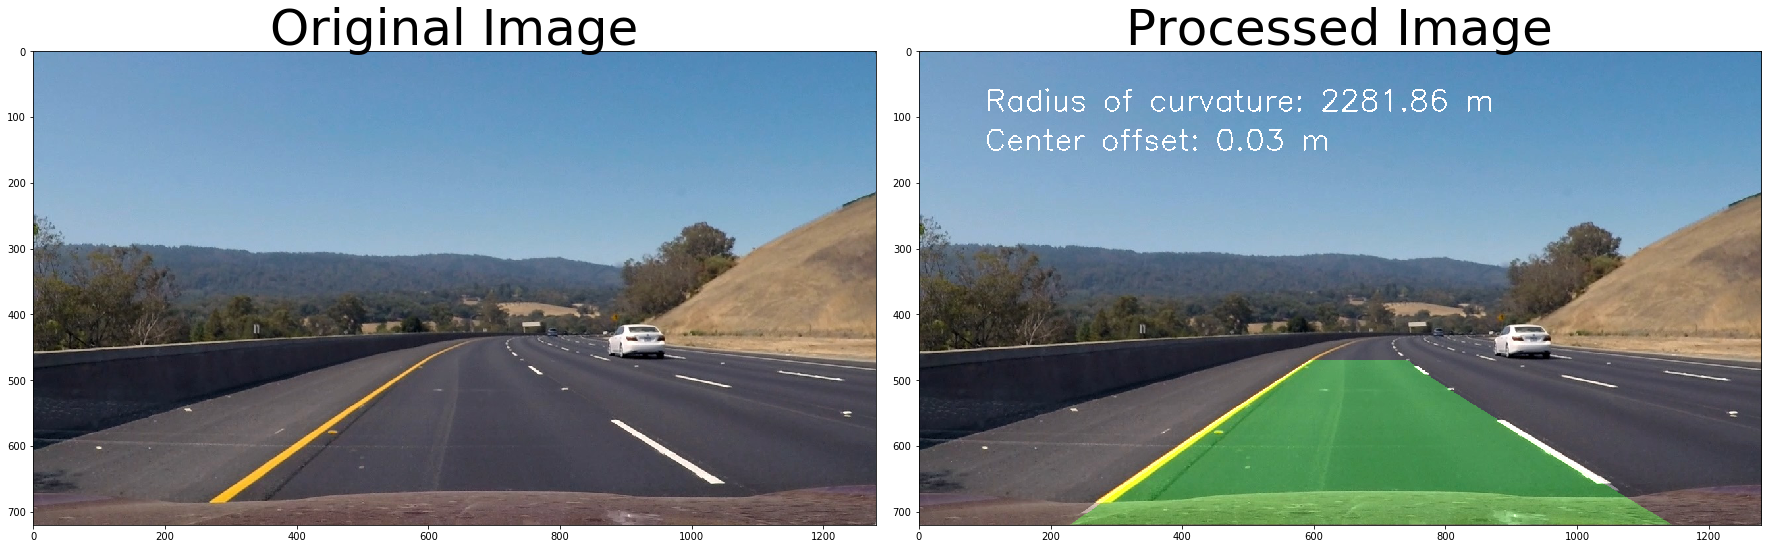

In [18]:
img = mpimg.imread('test_images/test3.jpg')

# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
avg_line_diff = 0

# Apply pipeline
processed = pipeline_final(img)

# Plot the 2 images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(processed, cmap='gray')
ax2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [20]:
# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
avg_line_diff = 0


output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline_final) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [07:40<00:00,  2.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 37s, sys: 49.4 s, total: 5min 26s
Wall time: 7min 43s


In [21]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output))

In [24]:
# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
avg_line_diff = 0


challenge_output = 'challenge_video_solution.mp4'
clip2 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip2.fl_image(pipeline_final) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video challenge_video_solution.mp4
[MoviePy] Writing video challenge_video_solution.mp4


100%|██████████| 485/485 [03:01<00:00,  2.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_solution.mp4 

CPU times: user 1min 45s, sys: 18 s, total: 2min 3s
Wall time: 3min 4s


In [26]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(challenge_output))